# Library and Dataset Preparation

In [109]:
import cv2
import numpy as np
import os
import joblib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import mahotas as mt
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("Import all librarys successful.")

Import all librarys successful.


In [ ]:
dataset_path = r"D:\dataset\data sekunder"

In [111]:
categories = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print("Category founded:", categories)

Category founded: ['busuk daun', 'jamur daun', 'sehat', 'septoria']


# Image Preprocessing and Segmentation

In [112]:
def preprocess_segment(image_path):

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to read image from path: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (512, 512))
    brightness = 5
    adjusted_image = cv2.convertScaleAbs(resized_image, alpha=1, beta=brightness)
    blurred_image = cv2.GaussianBlur(adjusted_image, (7, 7), 0)
    hsv = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2HSV)

    lower_green = np.array([35, 30, 30])
    upper_green = np.array([90, 255, 255])
    lower_brown = np.array([10, 30, 10])
    upper_brown = np.array([80, 255, 255])
    lower_yellow = np.array([10, 50, 40])
    upper_yellow = np.array([40, 255, 255])

    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    mask_combined = cv2.bitwise_or(mask_green, cv2.bitwise_or(mask_brown, mask_yellow))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask_cleaned = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=2)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cleaned_mask = np.zeros_like(mask_cleaned)
    min_contour_area = 2500
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if area > min_contour_area and 0.1 < aspect_ratio < 3.0:
            cv2.drawContours(cleaned_mask, [contour], -1, 255, thickness=cv2.FILLED)

    segmented = cv2.bitwise_and(resized_image, resized_image, mask=cleaned_mask)

    return segmented

# Feature Extraction

In [113]:
from math import radians
bins = 8

def extract_hsv_histogram(segmented):
    hsv = cv2.cvtColor(segmented, cv2.COLOR_RGB2HSV)
    hist_h = cv2.calcHist([hsv], [0], None, [bins], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [bins], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [bins], [0, 256])
    hist_features = np.concatenate([hist_h.flatten(), hist_s.flatten(), hist_v.flatten()])
    return hist_features / np.sum(hist_features)

def extract_glcm_features(segmented):
    gray = cv2.cvtColor(segmented, cv2.COLOR_RGB2GRAY)
    angles = [radians(0), radians(45), radians(90), radians(135)]
    glcm = graycomatrix(gray, distances=[1], angles=angles, levels=256, symmetric=True, normed=True)

    contrast = np.mean(graycoprops(glcm, 'contrast'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))

    return np.array([contrast, correlation, energy, homogeneity])

In [114]:
X, y = [], []

for category in categories:
    category_path = os.path.join(dataset_path, category)

    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        
        segmented = preprocess_segment(image_path)
        if segmented is not None:
            hsv_features = extract_hsv_histogram(segmented)
            glcm_features = extract_glcm_features(segmented)

            features = np.concatenate((hsv_features, glcm_features))
            X.append(features)
            y.append(category)

X = np.array(X)
y = np.array(y)

print(f"Dataset prepared with {X.shape[0]} samples dan {X.shape[1]} fitur.")

np.savez("static/feature extraction/dataset_tomat_features.npz", X=X, y=y)

Dataset prepared with 4000 samples dan 28 fitur.


In [115]:
data = np.load("static/Feature Extraction/dataset_tomat_features.npz", allow_pickle=True)
X, y = data["X"], data["y"]

print(f"Dataset loaded with {X.shape[0]} sampeles and {X.shape[1]} fitur.")

Dataset loaded with 4000 sampeles and 28 fitur.


In [116]:
unique_labels = np.unique(y)
print("Unique labels in dataset:", unique_labels)

Unique labels in dataset: ['busuk daun' 'jamur daun' 'sehat' 'septoria']


# Model Training

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [118]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [119]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [ 'scale', 'auto'],
    'kernel': ['linear', 'poly', 'rbf'],
}

In [120]:
svm = SVC()
grid_search = GridSearchCV(svm, param_grid,cv=5,scoring='accuracy', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [121]:
best_svm = grid_search.best_estimator_

In [122]:
y_pred = best_svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Model Accuracy: {accuracy * 100:.2f}%")

SVM Model Accuracy: 93.75%


In [123]:
print("Decision function shape:", best_svm.decision_function_shape)

Decision function shape: ovr


# Save and Load Model

In [124]:
joblib.dump(best_svm, "model/svm_model.pkl")
joblib.dump(scaler, "model/scaler.pkl")

print("\nSVM model saved successfully as 'svm_model.pkl' and 'scaler.pkl'.")


SVM model saved successfully as 'svm_model.pkl' and 'scaler.pkl'.


In [125]:
svm_model = joblib.load("model/svm_model.pkl")
scaler = joblib.load("model/scaler.pkl")

def predict_tomato_disease(features):
    features = np.array(features).reshape(1, -1)
    features = scaler.transform(features)
    prediction = svm_model.predict(features)[0]
    return prediction

# Model Evaluation

Confusion Matrix

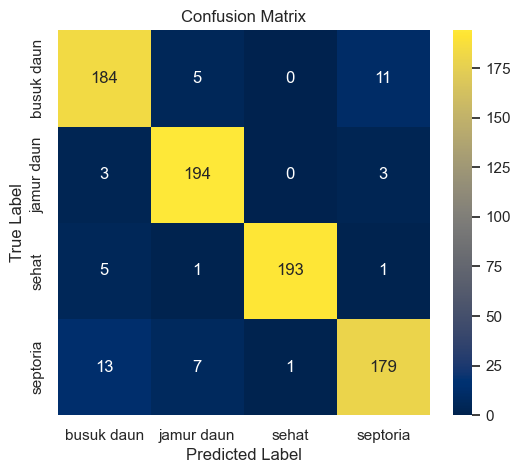

In [126]:
y_pred = svm_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="cividis", xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [127]:
for i, class_label in enumerate(categories):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    print(f"Class {class_label}: TP={TP}, FN={FN}, FP={FP}, TN={TN}")

Class busuk daun: TP=184, FN=16, FP=21, TN=579
Class jamur daun: TP=194, FN=6, FP=13, TN=587
Class sehat: TP=193, FN=7, FP=1, TN=599
Class septoria: TP=179, FN=21, FP=15, TN=585


Training & Testing Accuracy

In [128]:
train_accuracy = accuracy_score(y_train, svm_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9697
Testing Accuracy: 0.9375


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16344\2720323026.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=accuracies, palette=palette)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16344\2720323026.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.barplot(x=labels, y=accuracies, palette=palette)


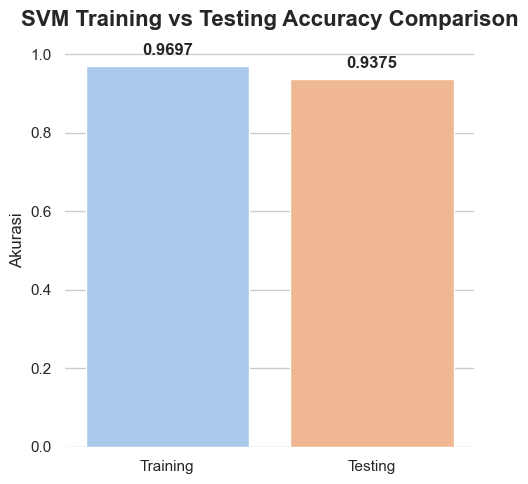

In [129]:
train_accuracy = accuracy_score(y_train, svm_model.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)
labels = ['Training', 'Testing']
accuracies = [train_accuracy, test_accuracy]
sns.set(style='whitegrid')
plt.figure(figsize=(5, 5))
palette = sns.color_palette("pastel")
ax = sns.barplot(x=labels, y=accuracies, palette=palette)

for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('SVM Training vs Testing Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Akurasi', fontsize=12)
plt.ylim(0, 1.05)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

Classification Report

In [130]:
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

  busuk daun       0.90      0.92      0.91       200
  jamur daun       0.94      0.97      0.95       200
       sehat       0.99      0.96      0.98       200
    septoria       0.92      0.90      0.91       200

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



Hyperparameter Tuning 

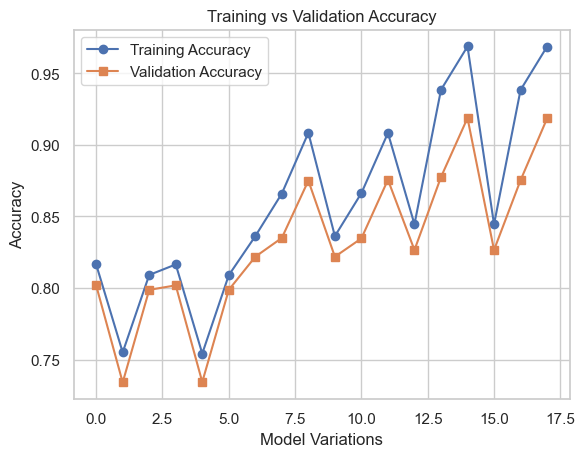

In [131]:
train_scores = grid_search.cv_results_['mean_train_score']
val_scores = grid_search.cv_results_['mean_test_score']

plt.plot(train_scores, label="Training Accuracy", marker='o')
plt.plot(val_scores, label="Validation Accuracy", marker='s')

plt.xlabel("Model Variations")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Save Feature Extraction Dataset as CSV

In [132]:
data = np.column_stack((X, y))
hsv_columns = [f'H_bin_{i}' for i in range(bins)] + \
              [f'S_bin_{i}' for i in range(bins)] + \
              [f'V_bin_{i}' for i in range(bins)]
glcm_columns = ['contrast', 'correlation', 'energy', 'homogeneity']
columns = hsv_columns + glcm_columns + ['label']
df = pd.DataFrame(data, columns=columns)
df.to_csv("static/feature extraction/extraction_feature.csv", index=False)

print("Feature extraction dataset saved successfully as CSV with", len(columns), "column.")

Feature extraction dataset saved successfully as CSV with 29 column.


# Load Feature Extraction Dataset

In [133]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

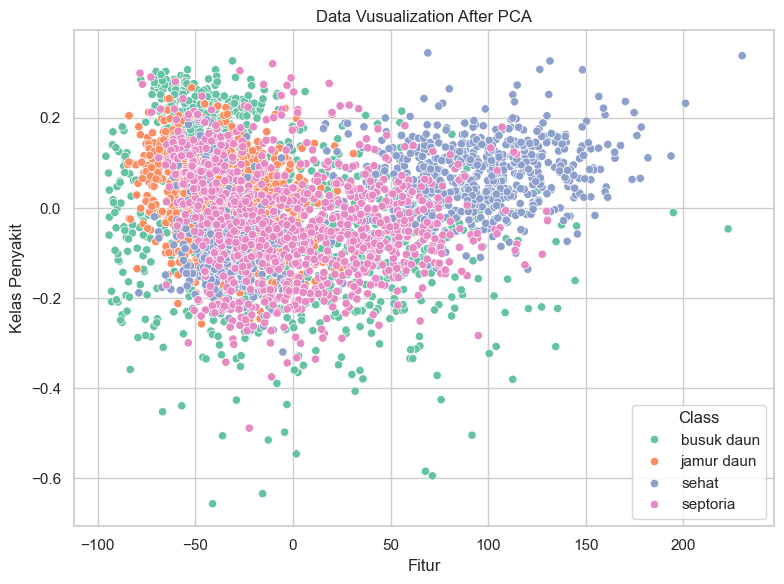

In [134]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set2')
plt.title('Data Vusualization After PCA')
plt.xlabel('Fitur')
plt.ylabel('Kelas Penyakit')
plt.legend(title='Class')
plt.grid(True)
plt.tight_layout()
plt.show()

In [135]:
data = pd.read_csv('static/feature extraction/extraction_feature.csv')

In [136]:
filtered_data_busuk_daun = data[data['label'] == 'busuk daun'].head(10)
filtered_data = pd.concat([filtered_data_busuk_daun])
pd.set_option('display.max_columns', 29)
filtered_data

,H_bin_0,H_bin_1,H_bin_2,H_bin_3,H_bin_4,H_bin_5,H_bin_6,H_bin_7,S_bin_0,S_bin_1,S_bin_2,S_bin_3,S_bin_4,S_bin_5,S_bin_6,S_bin_7,V_bin_0,V_bin_1,V_bin_2,V_bin_3,V_bin_4,V_bin_5,V_bin_6,V_bin_7,contrast,correlation,energy,homogeneity,label
0,0.259430,0.027602,0.046215,0.000000,0.000000,0.000000,0.000036,0.000051,0.257351,0.015481,0.051412,0.008556,0.000464,0.000042,0.000015,0.000011,0.256622,0.000590,0.001252,0.026087,0.037041,0.010292,0.001447,0.000001,79.932208,0.986372,0.767009,0.813931,busuk daun
1,0.222651,0.046193,0.064372,0.000036,0.000011,0.000001,0.000003,0.000066,0.216170,0.010535,0.059751,0.028653,0.010282,0.004589,0.002022,0.001331,0.220193,0.004391,0.012440,0.030755,0.050070,0.014736,0.000741,0.000006,121.679867,0.981770,0.643287,0.688384,busuk daun
2,0.258293,0.027006,0.048035,0.000000,0.000000,0.000000,0.000000,0.000000,0.258078,0.003440,0.008963,0.042252,0.018449,0.002151,0.000000,0.000000,0.257891,0.000248,0.002001,0.034485,0.033685,0.004927,0.000095,0.000000,47.282026,0.990074,0.771604,0.823026,busuk daun
3,0.286358,0.046953,0.000022,0.000000,0.000000,0.000000,0.000000,0.000001,0.279507,0.006682,0.014132,0.010417,0.009822,0.008333,0.003908,0.000534,0.279500,0.001203,0.006124,0.017504,0.022710,0.005587,0.000704,0.000000,61.846630,0.984369,0.835024,0.866662,busuk daun
4,0.278151,0.039839,0.015185,0.000134,0.000018,0.000001,0.000000,0.000005,0.204866,0.029935,0.067685,0.019735,0.007107,0.002987,0.000854,0.000164,0.204803,0.005126,0.008022,0.021615,0.041237,0.039055,0.013191,0.000284,190.253688,0.979887,0.609358,0.649417,busuk daun
5,0.296107,0.015544,0.021683,0.000000,0.000000,0.000000,0.000000,0.000000,0.295657,0.003269,0.004031,0.014315,0.010918,0.005081,0.000052,0.000010,0.295572,0.001994,0.004597,0.017348,0.012011,0.001537,0.000275,0.000000,33.775274,0.984867,0.884838,0.913267,busuk daun
6,0.301750,0.006407,0.025176,0.000000,0.000000,0.000000,0.000000,0.000000,0.300817,0.003161,0.007586,0.019834,0.001826,0.000098,0.000011,0.000000,0.300638,0.000127,0.001383,0.017892,0.012213,0.001077,0.000003,0.000000,33.509501,0.984777,0.900484,0.924016,busuk daun
7,0.275889,0.057134,0.000114,0.000000,0.000000,0.000000,0.000104,0.000092,0.272644,0.010156,0.016108,0.018478,0.011208,0.003112,0.001213,0.000415,0.272127,0.004088,0.007861,0.019838,0.019990,0.007517,0.001905,0.000008,76.058199,0.982953,0.812742,0.843265,busuk daun
8,0.261576,0.041528,0.029916,0.000050,0.000102,0.000032,0.000036,0.000094,0.243093,0.008378,0.029284,0.026094,0.015160,0.006805,0.002733,0.001787,0.252031,0.003805,0.012934,0.026691,0.030104,0.007544,0.000224,0.000000,81.887254,0.982873,0.725237,0.770198,busuk daun
9,0.201981,0.029257,0.101485,0.000518,0.000022,0.000000,0.000000,0.000071,0.190014,0.019578,0.039861,0.034261,0.022685,0.014648,0.008322,0.003963,0.211987,0.025405,0.031703,0.042622,0.019197,0.002332,0.000089,0.000000,140.144401,0.965072,0.564186,0.645953,busuk daun


In [137]:
filtered_data_jamur_daun = data[data['label'] == 'jamur daun'].head(10)
filtered_data = pd.concat([filtered_data_jamur_daun])
pd.set_option('display.max_columns', 29)
filtered_data

,H_bin_0,H_bin_1,H_bin_2,H_bin_3,H_bin_4,H_bin_5,H_bin_6,H_bin_7,S_bin_0,S_bin_1,S_bin_2,S_bin_3,S_bin_4,S_bin_5,S_bin_6,S_bin_7,V_bin_0,V_bin_1,V_bin_2,V_bin_3,V_bin_4,V_bin_5,V_bin_6,V_bin_7,contrast,correlation,energy,homogeneity,label
1000,0.267882,0.003531,0.034288,0.027490,0.000142,0.000000,0.000000,0.000000,0.268125,0.005090,0.019225,0.033525,0.006252,0.000994,0.000116,0.000006,0.267961,0.003609,0.029443,0.027726,0.004531,0.000062,0.000001,0.000000,42.751624,0.981563,0.801365,0.841208,jamur daun
1001,0.228209,0.031399,0.073518,0.000155,0.000028,0.000019,0.000005,0.000000,0.226566,0.008999,0.033569,0.041890,0.014666,0.004499,0.002195,0.000949,0.234027,0.017120,0.041822,0.032003,0.007620,0.000730,0.000011,0.000000,69.250305,0.977365,0.674477,0.731167,jamur daun
1002,0.228678,0.085578,0.018523,0.000065,0.000075,0.000123,0.000141,0.000150,0.222551,0.002981,0.006203,0.029676,0.045714,0.015188,0.005333,0.005689,0.234191,0.006220,0.010911,0.030968,0.040011,0.010698,0.000334,0.000000,81.431420,0.985444,0.662351,0.732127,jamur daun
1003,0.229252,0.004332,0.096460,0.002986,0.000286,0.000018,0.000000,0.000000,0.229457,0.005248,0.009338,0.035828,0.042997,0.009107,0.001205,0.000154,0.229281,0.005791,0.047681,0.047310,0.003256,0.000014,0.000000,0.000000,35.974438,0.987111,0.684704,0.773484,jamur daun
1004,0.223550,0.080888,0.028765,0.000043,0.000014,0.000003,0.000014,0.000056,0.219823,0.004826,0.018414,0.035781,0.031127,0.014042,0.005812,0.003510,0.227848,0.005349,0.010961,0.036209,0.044718,0.007723,0.000521,0.000003,84.555965,0.985244,0.654878,0.718015,jamur daun
1005,0.246939,0.000306,0.027381,0.058164,0.000543,0.000000,0.000000,0.000000,0.247434,0.009425,0.015087,0.037894,0.021493,0.001898,0.000092,0.000010,0.247496,0.049470,0.030739,0.004523,0.001071,0.000034,0.000000,0.000000,34.192208,0.973978,0.738054,0.810498,jamur daun
1006,0.222154,0.022779,0.088114,0.000272,0.000014,0.000000,0.000000,0.000000,0.222176,0.008539,0.039429,0.027306,0.016782,0.013611,0.004951,0.000540,0.222944,0.007214,0.035826,0.040520,0.020832,0.005791,0.000207,0.000000,73.610621,0.983468,0.662231,0.714891,jamur daun
1007,0.233060,0.073579,0.026559,0.000024,0.000008,0.000072,0.000003,0.000028,0.230708,0.007587,0.013613,0.034669,0.030978,0.011716,0.003094,0.000968,0.237315,0.006237,0.023571,0.045024,0.020372,0.000788,0.000027,0.000000,61.896758,0.984944,0.686761,0.740747,jamur daun
1008,0.228518,0.002955,0.015737,0.085272,0.000851,0.000000,0.000000,0.000000,0.229188,0.015939,0.069973,0.017029,0.001062,0.000142,0.000000,0.000000,0.228563,0.004709,0.046059,0.048478,0.005416,0.000109,0.000000,0.000000,48.972624,0.985711,0.682391,0.764330,jamur daun
1009,0.236863,0.066003,0.030406,0.000056,0.000004,0.000001,0.000000,0.000000,0.233790,0.004522,0.014811,0.040979,0.023279,0.009716,0.004292,0.001945,0.240103,0.016584,0.036180,0.033375,0.006756,0.000334,0.000001,0.000000,79.572586,0.973358,0.696942,0.739651,jamur daun


In [138]:
filtered_data_sehat = data[data['label'] == 'sehat'].head(10)
filtered_data = pd.concat([filtered_data_sehat])
pd.set_option('display.max_columns', 29)
filtered_data

,H_bin_0,H_bin_1,H_bin_2,H_bin_3,H_bin_4,H_bin_5,H_bin_6,H_bin_7,S_bin_0,S_bin_1,S_bin_2,S_bin_3,S_bin_4,S_bin_5,S_bin_6,S_bin_7,V_bin_0,V_bin_1,V_bin_2,V_bin_3,V_bin_4,V_bin_5,V_bin_6,V_bin_7,contrast,correlation,energy,homogeneity,label
2000,0.192088,0.000884,0.139737,0.000575,0.000050,0.000000,0.000000,0.000000,0.192603,0.080858,0.057921,0.001736,0.000202,0.000014,0.000000,0.000000,0.192088,0.000551,0.002153,0.075106,0.062668,0.000768,0.000000,0.000000,58.175950,0.991072,0.573290,0.673231,sehat
2001,0.193340,0.025281,0.114614,0.000010,0.000013,0.000004,0.000000,0.000071,0.188491,0.007000,0.076120,0.046764,0.009809,0.003309,0.001486,0.000355,0.196115,0.002239,0.008728,0.028493,0.066291,0.030102,0.001355,0.000010,160.343748,0.980104,0.559888,0.619783,sehat
2002,0.226930,0.037978,0.068174,0.000003,0.000006,0.000062,0.000104,0.000076,0.224317,0.048278,0.035714,0.013602,0.005259,0.002357,0.001887,0.001919,0.228790,0.010153,0.022982,0.031281,0.027096,0.011113,0.001856,0.000061,181.606302,0.968361,0.664608,0.696163,sehat
2003,0.160390,0.107549,0.064887,0.000000,0.000000,0.000013,0.000304,0.000191,0.159546,0.101584,0.038665,0.014535,0.009584,0.005806,0.002660,0.000954,0.165820,0.025930,0.033994,0.049993,0.041564,0.013986,0.001904,0.000144,233.189292,0.965238,0.462242,0.516071,sehat
2004,0.186382,0.001071,0.145728,0.000153,0.000000,0.000000,0.000000,0.000000,0.186991,0.058896,0.082737,0.004636,0.000072,0.000000,0.000000,0.000000,0.186382,0.000118,0.001788,0.085938,0.058159,0.000949,0.000000,0.000000,64.202785,0.989833,0.555902,0.675447,sehat
2005,0.199999,0.050470,0.082825,0.000024,0.000000,0.000000,0.000000,0.000015,0.200089,0.058111,0.036449,0.017935,0.009492,0.005165,0.003171,0.002921,0.205399,0.022594,0.026709,0.029556,0.028804,0.015868,0.004206,0.000197,211.178009,0.967740,0.587596,0.627555,sehat
2006,0.181435,0.048290,0.103559,0.000000,0.000000,0.000000,0.000014,0.000036,0.179658,0.057489,0.057281,0.024743,0.009579,0.003381,0.000982,0.000220,0.181538,0.013552,0.031722,0.046940,0.043591,0.014362,0.001578,0.000051,198.007515,0.970535,0.530877,0.572642,sehat
2007,0.175875,0.132401,0.025047,0.000000,0.000000,0.000000,0.000000,0.000010,0.173799,0.009391,0.055497,0.059547,0.023296,0.007848,0.002804,0.001151,0.176357,0.012255,0.024326,0.049931,0.048289,0.019410,0.002714,0.000051,225.930531,0.968387,0.516052,0.556013,sehat
2008,0.188585,0.004058,0.140310,0.000353,0.000028,0.000000,0.000000,0.000000,0.188986,0.024562,0.112142,0.006902,0.000519,0.000127,0.000078,0.000018,0.188585,0.001392,0.003652,0.074968,0.063206,0.001531,0.000000,0.000000,54.945808,0.991511,0.562614,0.699918,sehat
2009,0.245886,0.001078,0.085349,0.000983,0.000037,0.000000,0.000000,0.000000,0.246526,0.053646,0.032168,0.000788,0.000108,0.000037,0.000023,0.000037,0.245948,0.000792,0.001673,0.034323,0.048045,0.002546,0.000006,0.000000,63.318366,0.988699,0.735006,0.798491,sehat


In [139]:

filtered_data_septoria = data[data['label'] == 'septoria'].head(10)
filtered_data = pd.concat([filtered_data_septoria])
pd.set_option('display.max_columns', 29)
filtered_data

,H_bin_0,H_bin_1,H_bin_2,H_bin_3,H_bin_4,H_bin_5,H_bin_6,H_bin_7,S_bin_0,S_bin_1,S_bin_2,S_bin_3,S_bin_4,S_bin_5,S_bin_6,S_bin_7,V_bin_0,V_bin_1,V_bin_2,V_bin_3,V_bin_4,V_bin_5,V_bin_6,V_bin_7,contrast,correlation,energy,homogeneity,label
3000,0.222677,0.059772,0.050746,0.000029,0.000001,0.000006,0.000020,0.000081,0.217036,0.003456,0.005969,0.016426,0.055400,0.027879,0.005617,0.001551,0.217105,0.003958,0.009469,0.038509,0.059212,0.004812,0.000267,0.000001,62.172134,0.989305,0.646928,0.726435,septoria
3001,0.204610,0.012208,0.116187,0.000290,0.000020,0.000001,0.000000,0.000017,0.203668,0.004261,0.023120,0.068961,0.027791,0.004598,0.000776,0.000159,0.206037,0.004906,0.043278,0.071222,0.007361,0.000518,0.000013,0.000000,92.451596,0.974691,0.606603,0.664462,septoria
3002,0.216353,0.099640,0.016975,0.000065,0.000015,0.000037,0.000090,0.000158,0.214920,0.003306,0.004553,0.009167,0.036535,0.059366,0.004854,0.000633,0.215104,0.002584,0.004389,0.018550,0.086591,0.006090,0.000025,0.000000,48.111489,0.992675,0.640489,0.761545,septoria
3003,0.195572,0.069917,0.067356,0.000226,0.000000,0.000031,0.000051,0.000181,0.188446,0.014977,0.053305,0.039773,0.021957,0.009471,0.003518,0.001886,0.198916,0.011818,0.035066,0.053546,0.030460,0.003483,0.000045,0.000000,99.540166,0.980318,0.559529,0.642484,septoria
3004,0.254617,0.077433,0.000565,0.000009,0.000004,0.000064,0.000132,0.000510,0.244298,0.003167,0.005262,0.009744,0.019566,0.032808,0.015055,0.003433,0.244123,0.004222,0.011327,0.031821,0.035590,0.006205,0.000046,0.000000,58.828249,0.988148,0.728898,0.772370,septoria
3005,0.244115,0.088785,0.000158,0.000000,0.000001,0.000000,0.000103,0.000172,0.242720,0.002818,0.003198,0.005672,0.035797,0.033175,0.006903,0.003049,0.242353,0.001584,0.004949,0.013025,0.046771,0.024197,0.000448,0.000008,60.297750,0.991244,0.724144,0.786912,septoria
3006,0.243580,0.033535,0.054813,0.001404,0.000001,0.000000,0.000000,0.000000,0.240473,0.014539,0.039998,0.018213,0.009974,0.005566,0.003017,0.001553,0.245974,0.013210,0.044570,0.025065,0.004106,0.000408,0.000000,0.000000,70.045585,0.973526,0.717106,0.760383,septoria
3007,0.171443,0.112619,0.048445,0.000605,0.000178,0.000028,0.000003,0.000013,0.160405,0.022333,0.076332,0.034367,0.017021,0.011931,0.007488,0.003456,0.167978,0.017957,0.021758,0.033218,0.050104,0.035557,0.006596,0.000167,232.794975,0.972635,0.475122,0.531833,septoria
3008,0.264170,0.060897,0.008161,0.000010,0.000008,0.000004,0.000018,0.000066,0.261072,0.002600,0.005653,0.013185,0.019142,0.012927,0.008409,0.010345,0.265481,0.008003,0.007614,0.008340,0.012458,0.016572,0.013115,0.001750,97.311459,0.984931,0.779956,0.806437,septoria
3009,0.215252,0.024338,0.093713,0.000000,0.000000,0.000000,0.000001,0.000029,0.212569,0.004640,0.007044,0.029929,0.066438,0.012616,0.000088,0.000009,0.212368,0.003058,0.006632,0.065028,0.045246,0.001001,0.000000,0.000000,56.229444,0.989014,0.633559,0.756648,septoria


# Feature Extraction Dataset Distribution Overview

In [140]:
data = {
    "contrast": [
        79.93,121.67,47.28,61.84,190.25,33.77,33.50,76.05,81.88,140.14, # busuk daun
        42.75,69.25,81.43,35.97,84.55,34.19,73.61,61.89,48.97,79.57,     # jamur daun
        58.17,160.34,181.60,233.18,64.20,211.17,198.00,225.93,54.94,63.31, # sehat
        62.17,92.45,48.11,99.54,58.82,60.29,70.04,232.79,97.31,56.22     # septoria
    ],
    "energy": [
        0.76,0.64,0.77,0.83,0.60,0.88,0.90,0.81,0.72,0.56, # busuk daun
        0.80,0.67,0.66,0.68,0.65,0.73,0.66,0.68,0.68,0.69, # jamur daun
        0.57,0.55,0.66,0.46,0.55,0.58,0.53,0.51,0.56,0.73, # sehat
        0.64,0.60,0.64,0.55,0.72,0.72,0.71,0.47,0.77,0.63  # septoria
    ],
    "homogeneity": [
        0.81,0.68,0.82,0.86,0.64,0.91,0.92,0.84,0.77,0.64, # busuk daun
        0.84,0.73,0.73,0.77,0.71,0.81,0.71,0.74,0.76,0.73, # jamur daun
        0.67,0.61,0.69,0.51,0.67,0.62,0.57,0.55,0.69,0.79, # sehat
        0.72,0.66,0.76,0.64,0.77,0.78,0.76,0.53,0.80,0.75  # septoria
    ],
    "label": (
        ["busuk daun"]*10 +
        ["jamur daun"]*10 +
        ["sehat"]*10 +
        ["septoria"]*10
    )
}

In [141]:
df = pd.DataFrame(data)

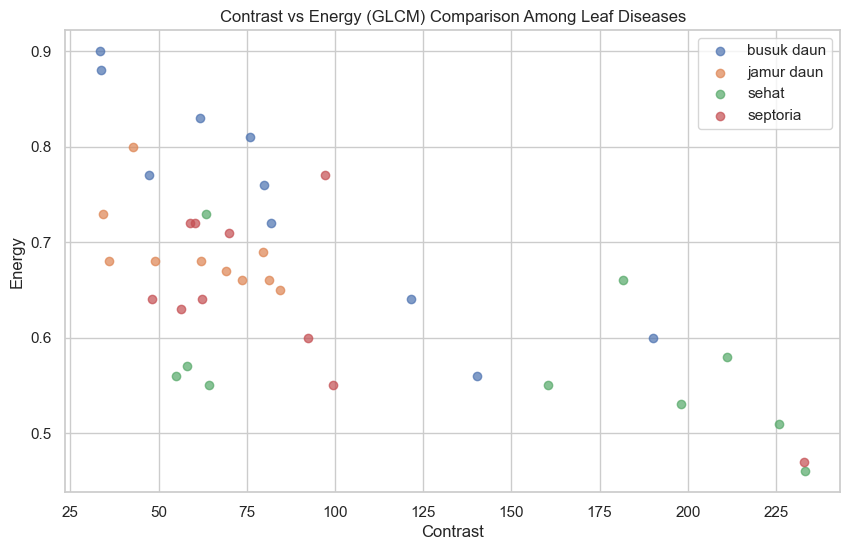

In [ ]:
plt.figure(figsize=(10,6))
for label, group in df.groupby("label"):
    plt.scatter(group["contrast"], group["energy"], label=label, alpha=0.7)

plt.xlabel("Contrast")
plt.ylabel("Energy")
plt.title("Contrast vs Energy (GLCM) Comparison Among Leaf Diseases")
plt.legend()
plt.show()

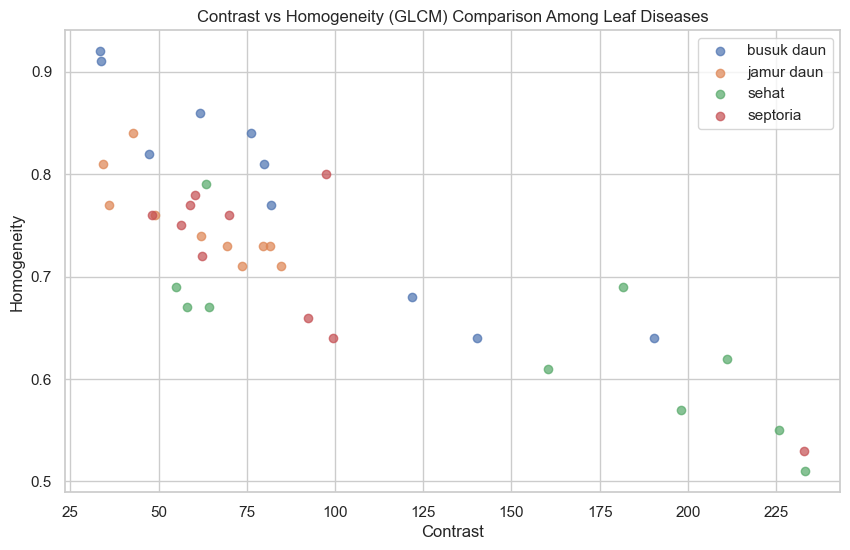

In [143]:
plt.figure(figsize=(10,6))
for label, group in df.groupby("label"):
    plt.scatter(group["contrast"], group["homogeneity"], label=label, alpha=0.7)

plt.xlabel("Contrast")
plt.ylabel("Homogeneity")
plt.title("Contrast vs Homogeneity (GLCM) Comparison Among Leaf Diseases")
plt.legend()
plt.show()

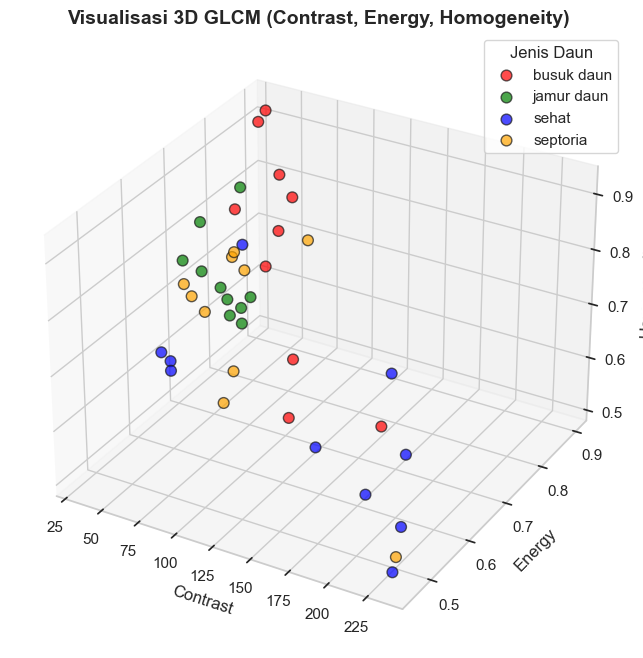

In [144]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

colors = {
    "busuk daun": "red",
    "jamur daun": "green",
    "sehat": "blue",
    "septoria": "orange"
}

for label, group in df.groupby("label"):
    ax.scatter(
        group["contrast"], group["energy"], group["homogeneity"],
        label=label, color=colors[label], s=60, alpha=0.7, edgecolor="k"
    )

ax.set_xlabel("Contrast")
ax.set_ylabel("Energy")
ax.set_zlabel("Homogeneity")
ax.set_title("Visualisasi 3D GLCM (Contrast, Energy, Homogeneity)", fontsize=14, fontweight="bold")
ax.legend(title="Jenis Daun")
plt.show()
